# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [8]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

final = final[0:50000]
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    42540
0     7460
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [5]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [79]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [14]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog w

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [8]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [9]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [10]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [15]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if len(e.lower()) > 2)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 50000/50000 [00:25<00:00, 1990.24it/s]


In [16]:
preprocessed_reviews[1500]

'great ingredients although chicken should have been rather than chicken broth the only thing not think belongs canola oil canola rapeseed not someting dog would ever find nature and did find rapeseed nature and eat would poison them today food industries have convinced the masses that canola oil safe and even better oil than olive virgin coconut facts though say otherwise until the late was poisonous until they figured out way fix that still like but could better'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [20]:
## Similartly you can do preprocessing for review summary also.
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if len(e.lower()) > 2)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 50000/50000 [00:23<00:00, 2100.30it/s]


In [21]:
preprocessed_text = []

for i in tqdm(range(len(preprocessed_reviews))):
  preprocessed_text.append(' '.join([preprocessed_reviews[i],preprocessed_summary[i]]))

100%|██████████| 50000/50000 [00:00<00:00, 641319.12it/s]


In [0]:
#split the dataset into train and test data
from sklearn.model_selection import train_test_split
train_data,test_data,y_train,y_test = train_test_split(preprocessed_text,final['Score'],test_size=0.2)

In [23]:
#create list of lists of sentences
list_of_sentence_train = []
for sentence in tqdm(train_data):
  list_of_sentence_train.append(sentence.split())
list_of_sentence_test = []
for sentence in tqdm(test_data):
  list_of_sentence_test.append(sentence.split())

100%|██████████| 10000/10000 [00:00<00:00, 112346.33it/s]


# LSTM

In [80]:
from nltk.util import ngrams
from nltk.lm.counter import NgramCounter
#from nltk.lm import Vocabulary

#count of unique words in train and test data
word_list_train = np.concatenate(list_of_sentence_train)
word_list_test = np.concatenate(list_of_sentence_test)
words_train = np.unique(word_list_train)
words_test = np.unique(word_list_test)
print('Number of unique words train data - %d and in test data - %d' %(len(words_train),len(words_test)))

Number of unique words train data - 41219 and in test data - 21442


In [28]:
#counts of the words in the train and test data

word_count_train = [ngrams(sent,1) for sent in tqdm(list_of_sentence_train)]
word_count_test = [ngrams(sent,1) for sent in tqdm(list_of_sentence_test)]
counts_train = NgramCounter(word_count_train)
counts_test = NgramCounter(word_count_test)

100%|██████████| 10000/10000 [00:00<00:00, 613794.60it/s]


In [29]:
#counts of the unique words
count_train = []
count_test = []
for word in tqdm(words_train):
  count_train.append(counts_train[word])
for word in tqdm(words_test):
  count_test.append(counts_test[word])

100%|██████████| 21442/21442 [00:00<00:00, 394720.34it/s]


In [30]:
#take the top 5000 words

top = np.argsort(count_train)[::-1]
top_5000 = np.take(words_train,top[0:5000])
print('Ten most frequent words - ',top_5000[0:10])

Ten most frequent words -  ['the' 'and' 'this' 'not' 'for' 'have' 'that' 'you' 'with' 'but']


In [31]:
#replace words in sentences of train and test data with rank of the top features

processed_sentence_train = []
processed_sentence_test = []

for sentence in tqdm(list_of_sentence_train):
  word_list = []
  for word in sentence:
    if word in top_5000:
      word_list.append(np.where(top_5000 == word)[0][0] + 1)
  processed_sentence_train.append(word_list)
  
for sentence in tqdm(list_of_sentence_test):
  word_list = []
  for word in sentence:
    if word in top_5000:
      word_list.append(np.where(top_5000 == word)[0][0] + 1)
  processed_sentence_test.append(word_list)

100%|██████████| 10000/10000 [01:13<00:00, 135.31it/s]


In [0]:
#pad the datapoints with zeros

review_length = 500
x_train = sequence.pad_sequences(processed_sentence_train,maxlen=review_length)
x_test = sequence.pad_sequences(processed_sentence_test,maxlen=review_length)

In [0]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [36]:
#model parameters
embedding_length = 64
batch_size = 512
n_epochs = 10
model = Sequential()

model.add(Embedding(len(top_5000)+1,embedding_length,input_length=review_length))
model.add(LSTM(60,return_sequences=True,recurrent_dropout=0.5))
model.add(LSTM(60,recurrent_dropout=0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 64)           320064    
_________________________________________________________________
lstm_3 (LSTM)                (None, 500, 60)           30000     
_________________________________________________________________
lstm_4 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                3904      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 383,073
Trainable params: 383,073
Non-trainable params: 0
_________________________________________________________________
None

In [37]:
#train 
history = model.fit(x_train,y_train,validation_split=0.2,batch_size=batch_size,epochs=n_epochs,verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 441s 14ms/step - loss: 0.4344 - acc: 0.8485 - val_loss: 0.2505 - val_acc: 0.8964
Epoch 2/10
32000/32000 [==============================] - 432s 13ms/step - loss: 0.1995 - acc: 0.9209 - val_loss: 0.1902 - val_acc: 0.9233
Epoch 3/10
32000/32000 [==============================] - 432s 13ms/step - loss: 0.1521 - acc: 0.9419 - val_loss: 0.1962 - val_acc: 0.9239
Epoch 4/10
32000/32000 [==============================] - 436s 14ms/step - loss: 0.1287 - acc: 0.9523 - val_loss: 0.1957 - val_acc: 0.9279
Epoch 5/10
32000/32000 [==============================] - 428s 13ms/step - loss: 0.1165 - acc: 0.9570 - val_loss: 0.1980 - val_acc: 0.9253
Epoch 6/10
32000/32000 [==============================] - 429s 13ms/step - loss: 0.1042 - acc: 0.9618 - val_loss: 0.2162 - val_acc: 0.9263
Epoch 7/10
32000/32000 [==============================] - 432s 13ms/step - loss: 0.0968 - acc: 0.9656 - val_loss: 0.2

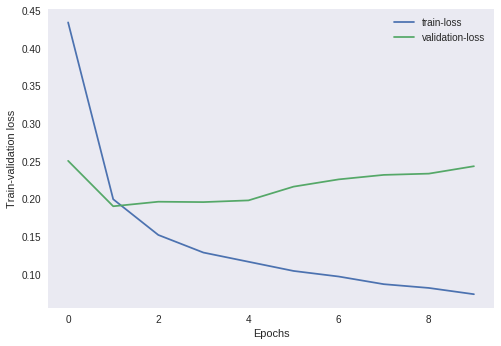

In [40]:
#train - validation errors plot

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = list(range(n_epochs))

plt.plot(epochs,loss,label='train-loss')
plt.plot(epochs,val_loss,label='validation-loss')
plt.xlabel('Epochs')
plt.ylabel('Train-validation loss')
plt.legend()
plt.grid()
plt.show()

**Observations:**
1. The train loss is close to zero, the test loss is increasing every epoch, the model is highly overfit.

In [78]:
#test loss and accuracy

score = model.evaluate(x_test,y_test)
print('Loss - ',score[0])
print('Test-accuracy - ',score[1])

10000/10000 [==============================] - 58s 6ms/step
Loss -  0.22375968236029148
Test-accuracy -  0.9277


# LSTM using pre-trained Glove Embedding

In [73]:
#code from https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
#load pre trained glove embedding 100dimensional

import numpy as np
#dictionary of words and rank
word_dict = dict(enumerate(top_5000,start=1))

embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(top_5000)+1, 100))
for i,word in word_dict.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


**LSTM**

In [74]:
embedding_length = 100
n_epochs = 10
batch_size = 512

model_2 = Sequential()

model_2.add(Embedding(len(top_5000)+1,embedding_length,weights=[embedding_matrix],input_length=max_length,trainable=False))
model_2.add(LSTM(60,return_sequences=True,recurrent_dropout=0.5))
model_2.add(LSTM(60,recurrent_dropout=0.5))
model_2.add(Dense(64,activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(1,activation='sigmoid'))

model_2.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

print(model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 100)          500100    
_________________________________________________________________
lstm_9 (LSTM)                (None, 500, 60)           38640     
_________________________________________________________________
lstm_10 (LSTM)               (None, 60)                29040     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                3904      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 571,749
Trainable params: 71,649
Non-trainable params: 500,100
_________________________________________________________________

In [75]:
#compile
model_2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

#train
history = model_2.fit(x_train,y_train,validation_split=0.2,epochs=n_epochs,batch_size=batch_size,verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 476s 15ms/step - loss: 0.4133 - acc: 0.8506 - val_loss: 0.3203 - val_acc: 0.8697
Epoch 2/10
32000/32000 [==============================] - 471s 15ms/step - loss: 0.2911 - acc: 0.8759 - val_loss: 0.2509 - val_acc: 0.8972
Epoch 3/10
32000/32000 [==============================] - 470s 15ms/step - loss: 0.2445 - acc: 0.8975 - val_loss: 0.2196 - val_acc: 0.9100
Epoch 4/10
32000/32000 [==============================] - 467s 15ms/step - loss: 0.2178 - acc: 0.9095 - val_loss: 0.2042 - val_acc: 0.9164
Epoch 5/10
32000/32000 [==============================] - 467s 15ms/step - loss: 0.2037 - acc: 0.9177 - val_loss: 0.1991 - val_acc: 0.9155
Epoch 6/10
32000/32000 [==============================] - 470s 15ms/step - loss: 0.1928 - acc: 0.9220 - val_loss: 0.1885 - val_acc: 0.9240
Epoch 7/10
32000/32000 [==============================] - 471s 15ms/step - loss: 0.1843 - acc: 0.9265 - val_loss: 0.1

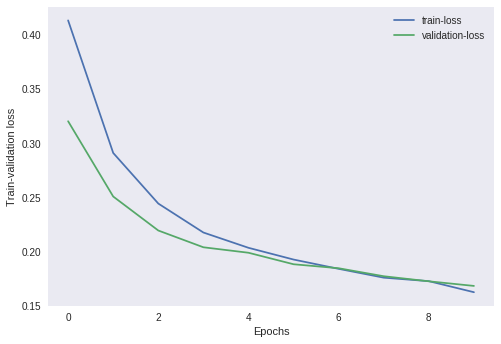

In [76]:
#Train-validation loss plot

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = list(range(n_epochs))
import matplotlib.pyplot as plt
plt.plot(epochs,loss,label='train-loss')
plt.plot(epochs,val_loss,label='validation-loss')
plt.xlabel('Epochs')
plt.ylabel('Train-validation loss')
plt.legend()
plt.grid()
plt.show()

In [77]:
score = model_2.evaluate(x_test,y_test)
print('Loss',score[0])
print('Accuracy on test data',score[1])

10000/10000 [==============================] - 63s 6ms/step
Loss 0.16650567417144777
Accuracy on test data 0.934


# Conclusion:

1. Data sample contains 50000 datapoints,(positive - 42540,negative - 7460).
2. The LSTM model easily overfits.
3. Overfitting can be decreased using dropout, dropout to the dense layer, changing the LSTM-units.
4. A balanced model is obtained by using the pre-trained glove embedding.
5. Loss - 0.166 ,
   Test-accuracy - 0.934